<a href="https://colab.research.google.com/github/Urdzik/Colab/blob/main/MDDL_Urdzik_CS26_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# По прикладу на основі схожого датасету yelp_polarity

In [2]:
!pip install --quiet datasets

In [ ]:
!pip install matplotlib

In [6]:
import datasets

In [8]:
yelp_polarity  = datasets.load_dataset("yelp_polarity")

Generating test split: 100%|██████████| 38000/38000 [00:00<00:00, 1741687.36 examples/s]


In [9]:
yelp_polarity

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 38000
    })
})

In [10]:
print(yelp_polarity.keys())

dict_keys(['train', 'test'])


In [12]:
train_data = yelp_polarity['train']
# test_data = yelp_polarity['test']

In [13]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 560000
})

In [14]:
train_data[100]["text"]

"In general I do like Shake N' Steak, but this location is a hit or miss location!  You never know what kind of quality or service you're going to find here.  A friend and myself went a few weeks back after a movie and it had to be one of the worst trips there EVER!  You can't entirely blame the waitress since she was the only one there for the entire place...poor scheduling on the manager's part. However, while she can't be accountable for the slooooow service, she was accountable for both orders being incorrect.  The burgers were over cooked and the fries were soggie and the milkshake was runny at best...\\n\\nBy far my worst visit to Steak n' Shake!"

In [15]:
!pip install --quiet spacy

In [16]:
import spacy
import tqdm
from typing import List, Tuple

spacy_nlp = spacy.blank("en")

def tokenize_spacy(text: str) -> List[str]:
  """Tokenize string with SpaCy. """

  tokens = spacy_nlp.tokenizer(text)
  return [str(token) for token in tokens]


def tokenize(text: str) -> List[str]:
  return tokenize_spacy(text)


tokenize_spacy("I can't find my $25! oleksiy@google.com http://google.com/ <b>")

['I',
 'ca',
 "n't",
 'find',
 'my',
 '$',
 '25',
 '!',
 'oleksiy@google.com',
 'http://google.com/',
 '<',
 'b',
 '>']

In [17]:
!pip install pystemmer

In [18]:
import Stemmer
from typing import List

def stem(tokens: List[str]) -> List[str]:
  """Lower-case and stem tokens. """

  stemmer = Stemmer.Stemmer("english")
  tokens = [tok.lower() for tok in tokens]
  return stemmer.stemWords(tokens)

example_tokens = tokenize(train_data[2]["text"])
stemmed_tokens = stem(example_tokens)


i do n't know what dr. goldberg was like befor   move to arizona , but let me tell you , stay away from this doctor and this offic . i was go to dr. johnson befor he left and goldberg took over when johnson left . he is not a care doctor . he is onli interest in the co - pay and have you come in for medic refil everi month . he will not give refil and could less about patient 's financi situat . tri to get your 90 day mail away pharmaci prescript through this guy is a joke . and to make matter even wors , his offic staff is incompet . 90 % of the time when you call the offic , they ll put you through to a voic mail , that no one ever answer or return your call . both my adult children and husband have decid to leav this practic after experienc such frustrat . the entir offic has an attitud like they are do you a favor . give me a break ! stay away from this doc and the practic . you deserv better and they will not be there when you realli need them . i have never felt compel to write a

In [19]:
for word in ("sing", "sings", "singing", "singer", "singers"):
  stemmed = stem([word])[0]
  print(f"{word:<20}   =>   {stemmed}")

sing                   =>   sing
sings                  =>   sing
singing                =>   sing
singer                 =>   singer
singers                =>   singer


In [20]:
from tqdm import tqdm

all_tokens = []
all_tokens_stemmed = []
for doc in tqdm(train_data):
  doc_tokens = tokenize(doc["text"])
  all_tokens += doc_tokens
  all_tokens_stemmed += stem(doc_tokens)

print("Original unique tokens: {:,}".format(len(set(all_tokens))))
print("Stemmed  unique tokens: {:,}".format(len(set(all_tokens_stemmed))))

100%|██████████| 560000/560000 [02:07<00:00, 4384.35it/s]


Original unique tokens: 775,042
Stemmed  unique tokens: 619,424


In [21]:
# Кастомні стоп-слова, спитав в ChatGPT які краще використати
custom_stop_words = [
    "the", "a", "an", "and", "in", "on", "at", "with", "for", "of", "by", "to",
    "was", "were", "be", "been", "am", "is", "are", "as", "from", "that",
    "this", "it", "you", "your", "we", "they", "he", "she", "my", "i", "me",
    "our", "us", "their", "them", "just", "very", "so", "if", "when", "then"
]
def remove_stop_words(tokens: List[str]) -> List[str]:
  return [token for token in tokens if token not in custom_stop_words]

['fantastic']

In [22]:
def preprocess(text: str) -> List[str]:
  tokens = tokenize(text)
  tokens = stem(tokens)
  tokens = remove_stop_words(tokens)
  return tokens

preprocess("I likes it!")

['like', '!']

Top 50 most common tokens account for 47.813044% of tokens
Top 50 tokens are: [('.', 3981740), ('the', 3688719), (',', 2709943), ('and', 2414839), ('i', 2193956), ('to', 1890266), ('a', 1881330), ('was', 1390129), (' ', 1312895), ('it', 1170696), ('of', 1109769), ('for', 861571), ('in', 858735), ('is', 851720), ('that', 747835), ('!', 689737), ('my', 665550), ('we', 623638), ('you', 597157), ('this', 592531), ('they', 592132), ('but', 572894), ('with', 568984), ("n't", 531387), ('on', 528575), ('not', 513399), ('have', 507586), ('had', 444681), ("'s", 431858), ('at', 420707), ('were', 419109), ('be', 387217), ('-', 387102), ('so', 383776), ('place', 359534), ('are', 347091), ('food', 329168), ('"', 328966), ('there', 321754), ('me', 299478), ('good', 298309), ('as', 292552), ('like', 288045), ('get', 285703), ('do', 282144), ('(', 281246), ('go', 272738), ('time', 272656), (')', 269200), ('out', 266307)]


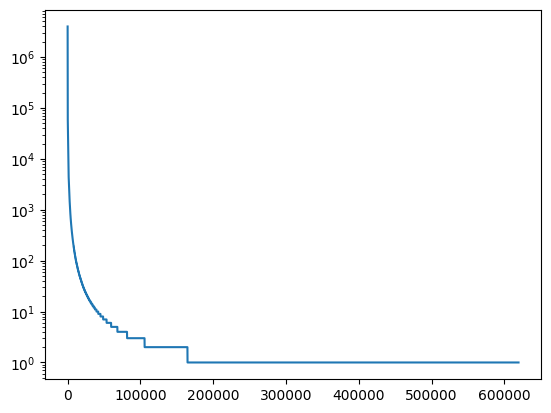

In [50]:
from collections import Counter
import matplotlib.pyplot as plt

# Корпус вже токенізовано в all_tokens та all_tokens_stemmed
assert all_tokens
assert all_tokens_stemmed

# Злічимо усі токени
token_counts = Counter(all_tokens_stemmed)

# Подивимося на 50 найчастотніших токенів
most_common = token_counts.most_common(50)

most_common_count = sum(count for token, count in most_common)
all_count = sum(token_counts.values())
print(f"Top {len(most_common)} most common tokens account for {most_common_count / all_count:%} of tokens")
print(f"Top {len(most_common)} tokens are: {most_common}")

# Розподіл токенів за частотою
plt.yscale("log")
plt.plot(sorted(token_counts.values(), reverse=True))

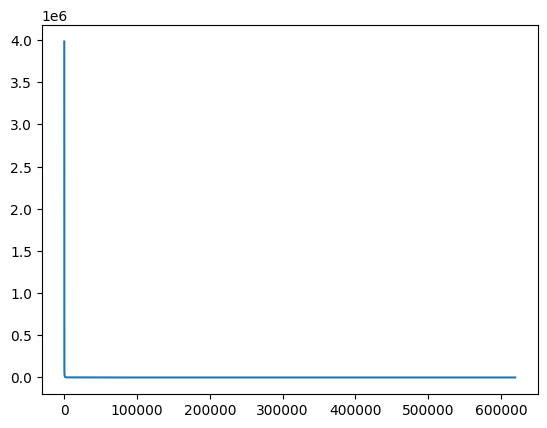

In [51]:
plt.plot(sorted(token_counts.values(), reverse=True))

In [52]:
VOCAB_SIZE = 5000
MIN_COUNT = 5

print(f"Vocab size before filtering: {len(token_counts):,}")

vocab_list = [token for token, count in token_counts.most_common()
              if count > MIN_COUNT
              and token not in custom_stop_words]

print(f"Vocab size after filtering: {len(vocab_list):,}")


vocab_list = vocab_list[:VOCAB_SIZE]
print(f"Final vocab size: {len(vocab_list):,}")

Vocab size before filtering: 619,424
Vocab size after filtering: 59,629
Final vocab size: 5,000


In [53]:
vocab_list[50:60]

['even',
 'more',
 'other',
 'friend',
 'got',
 'look',
 'could',
 'want',
 'come',
 'after']

In [54]:
class Vocabulary:

  def __init__(self, tokens, unk_token="<unk>"):
    self.unk_token = unk_token
    self.unk_index = 0
    self._itos = [unk_token] + tokens
    self._stoi = {token: index for index, token in enumerate(self._itos)}

  def stoi(self, token: str) -> int:
    """Return token index or `<unk>` index if `token` is not in the vocab.
    """
    return self._stoi.get(token, self.unk_index)


  def itos(self, index: int) -> str:
    """Return token by its `index`.

    Raise LookupError if `index` is out of vocabulary range.
    """

    return self._itos[index]

  @property
  def tokens(self):
    return self._itos

  def __len__(self) -> int:
    return len(self._itos)


vocab = Vocabulary(vocab_list)
print(f"Index of `dog` is {vocab.stoi('dog')}")
print(f"Token #42 is `{vocab.itos(42)}`")

Index of `dog` is 401
Token #42 is `realli`


In [55]:
def one_hot(token: str, vocab: Vocabulary) -> List[int]:
    # [0, 0, 0, 1, 0 ,0 ]
    result = [0] * len(vocab)
    index = vocab.stoi(token)
    result[index] = 1
    return result

In [57]:
vector_dog = one_hot("dog", vocab)
len(vector_dog)

5001

In [58]:
vector_dog[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [59]:
vector_dog.index(1)

401

In [60]:
vocab.itos(751)

'profession'